##-------------------------
## Name: Sankalp Indish
## Roll No: BEB75
## Title:  Build a machine learning model that predicts the type of people who survived the Titanic shipwreck using passenger data (i.e. name, age, gender, socio-economic class, etc.).
## Dataset Link: https://www.kaggle.com/competitions/titanic/data

In [7]:
pip show scikit-learn

Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.12/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: cuml-cu12, fastai, hdbscan, imbalanced-learn, libpysal, librosa, mlxtend, pynndescent, sentence-transformers, shap, sklearn-pandas, tsfresh, umap-learn, yellowbrick


In [2]:
# ================================================
# Phase 1: Import & Preprocessing
# ================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter


# Load dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
full = pd.concat([train.drop("Survived", axis=1), test], axis=0, sort=False)

In [3]:
# ================================================
# Phase 2: Data Fixing & Feature Engineering
# ================================================
# Extract Title from Name
full["Title"] = full["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
full["Title"] = full["Title"].replace(
    ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
full["Title"] = full["Title"].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

# Family features
full["FamilySize"] = full["SibSp"] + full["Parch"] + 1
full["IsAlone"] = (full["FamilySize"] == 1).astype(int)

# Cabin Deck
full["Deck"] = full["Cabin"].astype(str).str[0].replace("n", "Unknown")

# FarePerPerson
full["FarePerPerson"] = full["Fare"] / full["FamilySize"]

# Binning
full["AgeBin"] = pd.cut(full["Age"], bins=[0,12,18,35,50,80], labels=["Child","Teen","Adult","Mature","Senior"])
full["FareBin"] = pd.qcut(full["Fare"], 4, labels=False)

# Fill missing
for col in ["Embarked"]:
    full[col].fillna(full[col].mode()[0], inplace=True)
full["Fare"].fillna(full["Fare"].median(), inplace=True)
full["Age"].fillna(full["Age"].median(), inplace=True)
full["FarePerPerson"].fillna(full["Fare"].median(), inplace=True)

# Split back
train_fixed = full.iloc[:len(train)]
train_fixed["Survived"] = train["Survived"].values
test_fixed = full.iloc[len(train):]

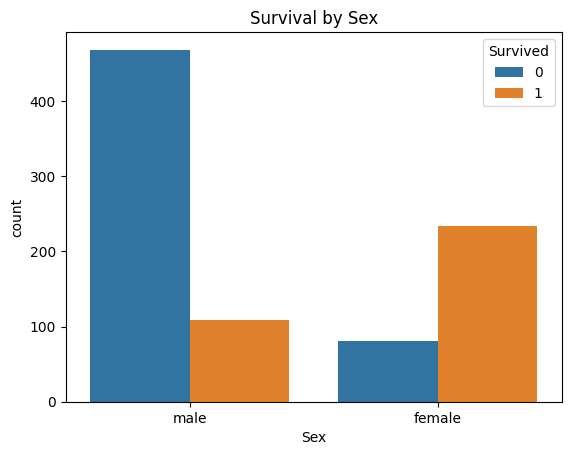

In [8]:
# ================================================
# Phase 3: EDA & Visualizations
# ================================================
sns.countplot(x="Sex", hue="Survived", data=train_fixed)
plt.title("Survival by Sex"); plt.show()

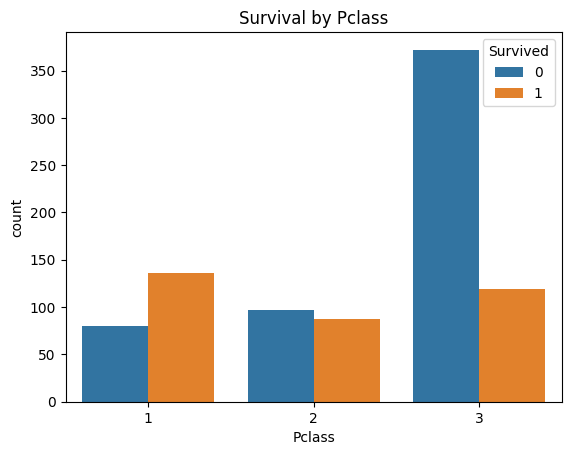

In [9]:
sns.countplot(x="Pclass", hue="Survived", data=train_fixed)
plt.title("Survival by Pclass"); plt.show()

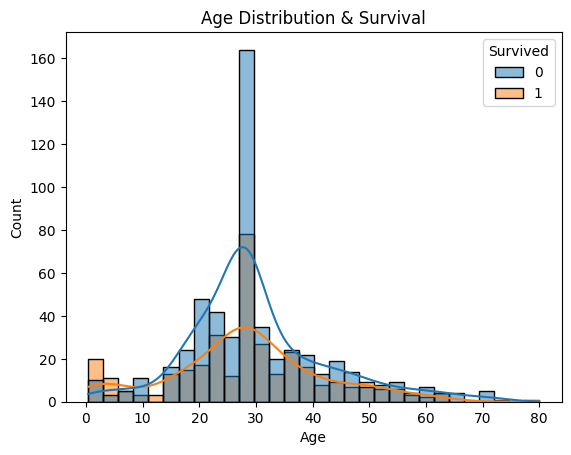

In [10]:
sns.histplot(train_fixed, x="Age", hue="Survived", bins=30, kde=True)
plt.title("Age Distribution & Survival"); plt.show()

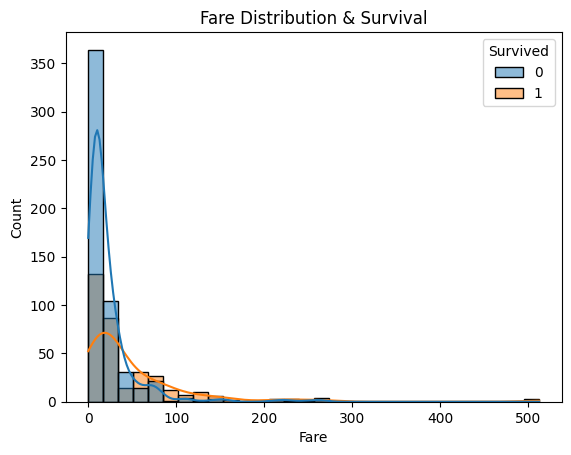

In [11]:
sns.histplot(train_fixed, x="Fare", hue="Survived", bins=30, kde=True)
plt.title("Fare Distribution & Survival"); plt.show()

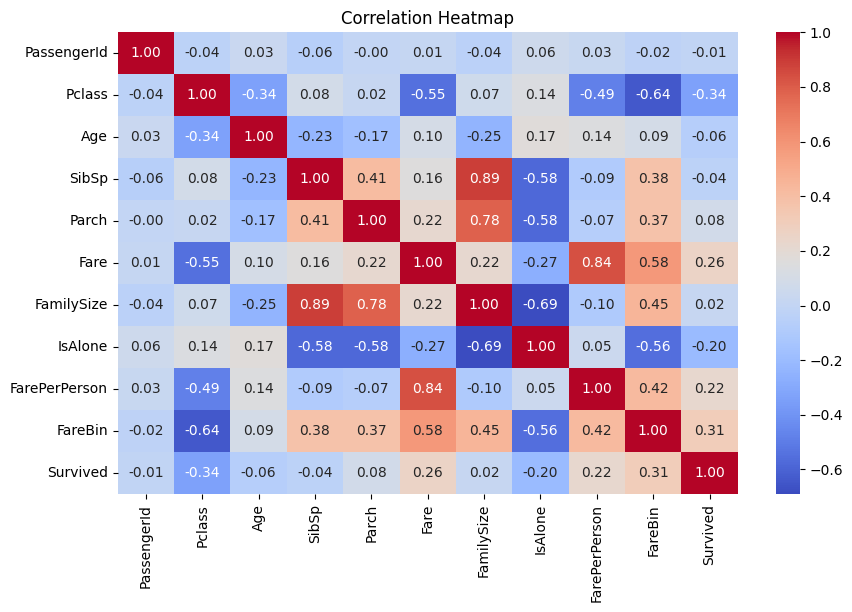

In [12]:
num_cols = train_fixed.select_dtypes(include=[np.number])
plt.figure(figsize=(10,6))
sns.heatmap(num_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap"); plt.show()

In [5]:
# ================================================
# Phase 4: Model Building
# ================================================
X = train_fixed.drop(["Survived","PassengerId","Name","Ticket","Cabin"], axis=1)
y = train_fixed["Survived"]

cat_cols = X.select_dtypes(include=["object","category"]).columns
num_cols = X.select_dtypes(include=[np.number]).columns

# Preprocessor
preprocessor = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

# Base models
rf = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=42)
xgb = XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.02,
                    subsample=0.8, colsample_bytree=0.8, eval_metric="logloss", random_state=42)
lgbm = LGBMClassifier(n_estimators=500, max_depth=5, learning_rate=0.02,
                      subsample=0.8, colsample_bytree=0.8, random_state=42)

# Stacking ensemble
stack = StackingClassifier(
    estimators=[("rf", rf), ("xgb", xgb), ("lgbm", lgbm)],
    final_estimator=LogisticRegression(max_iter=500),
    cv=5, n_jobs=-1
)

pipe = Pipeline([("preprocessor", preprocessor), ("model", stack)])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")

print("Cross-validation Accuracies:", scores)
print("Mean CV Accuracy:", scores.mean())


Cross-validation Accuracies: [0.84916201 0.83707865 0.82022472 0.8258427  0.85955056]
Mean CV Accuracy: 0.8383717280773336


✅ Submission file created!


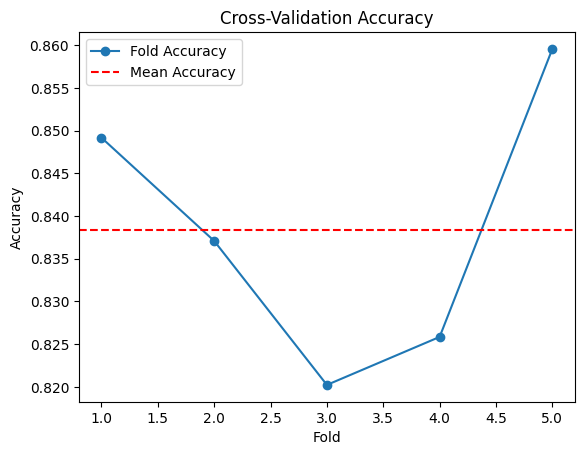

In [6]:
# ================================================
# Phase 5: Prediction & Saving
# ================================================
pipe.fit(X, y)
y_pred = pipe.predict(test_fixed.drop(["PassengerId","Name","Ticket","Cabin"], axis=1))

submission = pd.DataFrame({
    "PassengerId": test_fixed["PassengerId"],
    "Survived": y_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ Submission file created!")

# Save model
joblib.dump(pipe, "titanic_best_stack.joblib")

# Plot CV accuracy distribution
plt.plot(range(1, len(scores)+1), scores, marker="o", label="Fold Accuracy")
plt.axhline(scores.mean(), color="red", linestyle="--", label="Mean Accuracy")
plt.xlabel("Fold"); plt.ylabel("Accuracy"); plt.title("Cross-Validation Accuracy")
plt.legend(); plt.show()